#IMDb Data Analysis and Top 1% Movies and TV series

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, fbeta_score, precision_recall_curve, auc
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm.notebook import tqdm
import csv
from gensim.models.callbacks import CallbackAny2Vec
from itertools import groupby
from gensim.models import Word2Vec
import gensim
from pathlib import Path
import matplotlib.pyplot as plt
import os
import random
pd.options.display.max_columns = 999

In [ ]:
PATH = Path('/content/drive/MyDrive/Colab_Notebooks/imdb-dataset')

## Load Data

In [ ]:
def load_data(start_year, min_minutes, min_votes):
    title_basics = pd.read_csv(PATH / 'title.basics.tsv' / 'title.basics.tsv', sep='\t')
    title_ratings = pd.read_csv(PATH / 'title.ratings.tsv'/ 'title.ratings.tsv', sep='\t')
    title_basics.genres = title_basics.genres.apply(
                        lambda x: x.split(',') if ((type(x)!=float) & (x!=r'\N')) else ['no_genre'])

    title_basics.runtimeMinutes = (
     title_basics.runtimeMinutes.apply(lambda x: np.nan if not x.isdigit() else x).astype(float)
                                )
    
    title_basics = title_basics[
        title_basics.titleType.isin(['movie'])
        & ~title_basics.runtimeMinutes.isna()
        & (title_basics.runtimeMinutes <= 3.5 * 60)
        & title_basics.genres.apply(lambda x: 'Short' not in x)
        ]
    
    movies = pd.merge(title_basics, title_ratings, on='tconst', how='left')
    movies['startYear'] = movies['startYear'].apply(lambda x: np.nan if x == r'\N' else int(x))
    
    # MY CONDITIONS:
    movies = movies[movies.startYear > start_year].dropna(subset=['averageRating'])
    movies = movies[movies.runtimeMinutes >= min_minutes]
    movies = movies[movies.numVotes>=min_votes]
    return movies

In [ ]:
movies = load_data(start_year = 1960, min_minutes = 60, min_votes = 15)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
principals = pd.read_csv(PATH /'title.principals.tsv'/'title.principals.tsv',delimiter="\t")

In [ ]:
cast = principals[principals['category'].isin(['actor', 'actress'])]
crew = principals[~principals['category'].isin(['actor', 'actress'])]

In [ ]:
ordered_cast = pd.DataFrame(cast.groupby(by='tconst').apply(lambda x: [x for x in x['nconst']]))
ordered_cast = ordered_cast.reset_index().rename(columns={0: 'cast'})
ordered_cast.head(2)

,tconst,cast
0,tt0000005,"[nm0443482, nm0653042]"
1,tt0000007,"[nm0179163, nm0183947]"


In [ ]:
# If it went right, we should have no duplicated movies (tconst)
ordered_cast.duplicated('tconst').any()

False

In [ ]:
ordered_crew = pd.DataFrame(crew.groupby(by='tconst').apply(lambda x: [x for x in x['nconst']]))
ordered_crew = ordered_crew.reset_index().rename(columns={0: 'crew'})
ordered_crew.head(2)

,tconst,crew
0,tt0000001,"[nm1588970, nm0005690, nm0374658]"
1,tt0000002,"[nm0721526, nm1335271]"


In [ ]:
# If it went right, we should have no duplicated movies (tconst)
ordered_crew['tconst'].value_counts().max()

1

In [ ]:
movies = pd.merge(movies, ordered_cast, on='tconst', how='left').merge(ordered_crew, on='tconst', how='left')

# If it went right, we should have no duplicated movies (tconst)
movies.duplicated('tconst').any()

False

In [ ]:
# CHECK: Avengers Endgame
movies[movies['tconst']=='tt4154796']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,crew
115780,tt4154796,movie,Avengers: Endgame,Avengers: Endgame,0,2019.0,\N,181.0,"[Action, Adventure, Drama]",8.5,602740.0,"[nm0000375, nm0262635, nm0749263, nm1165110]","[nm0456158, nm0751577, nm0751648, nm1321655, n..."


We do however have some movies with no cast or crew.

In [ ]:
movies['cast'].isna().sum()

12260

In [ ]:
movies['crew'].isna().sum()

531

Let's check a couple.

In [ ]:
movies[movies['cast'].isna()].head(2)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,crew
53,tt0054050,movie,The Making of the President 1960,The Making of the President 1960,0,1963.0,\N,90.0,"[Documentary, History]",7.3,18.0,NaN,"[nm0142216, nm0300010, nm0448123, nm0633271, n..."
214,tt0054770,movie,The Crimebusters,The Crimebusters,0,1962.0,\N,88.0,"[Crime, Drama]",7.3,17.0,NaN,"[nm0818157, nm0725052, nm0300010, nm0683984, n..."


In [ ]:
movies['cast'].fillna('Unknown', inplace=True)
movies['crew'].fillna('Unknown', inplace=True)

## Word2Vec

In [ ]:
to_wtv = pd.DataFrame(principals.groupby(by='tconst').apply(lambda x: [x for x in x['nconst']])).reset_index().iloc[:, 1]
to_wtv.head(3)

0               [nm1588970, nm0005690, nm0374658]
1                          [nm0721526, nm1335271]
2    [nm0721526, nm5442194, nm1335271, nm5442200]
Name: 0, dtype: object

In [ ]:
wtv = Word2Vec(window=10, min_count=5)
wtv.build_vocab(to_wtv)
wtv.train(to_wtv, total_words=wtv.corpus_total_words, epochs=10)

(319604950, 364688170)

In [ ]:
from IPython.display import HTML, display
from bs4 import BeautifulSoup
import requests

def get_name(id):
    response = requests.get(f'https://www.imdb.com/name/{id}/')
    soup = BeautifulSoup(response.content)
    return soup.select('.header .itemprop')[0].text

def get_image(id):
    response = requests.get(f'https://www.imdb.com/name/{id}/')
    soup = BeautifulSoup(response.content)
    candidates = soup.select('#name-poster')
    return candidates[0].attrs['src'] if candidates else 'https://m.media-amazon.com/images/G/01/imdb/images/nopicture/medium/name-2135195744._CB466677935_.png'

def render_person(id):
    name = get_name(id)
    picture = get_image(id)
    return f"""
    <div style="width: 150px; text-align: center">
        <h4 style='margin-top: -5px'>{name}</h4>
        <div style='font-size:75%; margin-bottom: 5px'>{id}</div>
        <a href="https://www.imdb.com/name/{id}" target="_blank">
            <img style="width: 100px; display: block; margin-left: auto; margin-right: auto;" src="{picture}"/>
        </a>
    </div>
    """

def show_similars(id, n=10):
    if id in wtv.wv: 
        display(HTML(render_person(id)))
    renders = []
    for similar_id, score in wtv.wv.most_similar(id, topn=n):
        renders.append(render_person(similar_id))
        
    carousel = ''.join(
        [
            f'<div style="margin-left: 10px; float: left">{p}</div>' 
            for p in renders
        ]
        )
    display(HTML(f'<div style="width: 1800px">{carousel}</div>'))

def show_similars_tovector(id, n=10):
    renders = []
    
    for similar_id, score in wtv.wv.most_similar(id, topn=n):
        renders.append(render_person(similar_id))
        
    carousel = ''.join(
        [
            f'<div style="margin-left: 10px; float: left">{p}</div>' 
            for p in renders
        ]
    )
    display(HTML(f'<div style="width: 1800px">{carousel}</div>'))


In [ ]:
show_similars('nm0000138')

In [ ]:
show_similars('nm0000206')

In [ ]:
show_similars('nm1089991')

In [ ]:
show_similars('nm1297015')

Nice to see that results seem to make a lot of sense in most cases :) Let's now look for a random actor/actress. If our model is coherent, we should get other random not well-known people in return.

In [ ]:
random_actor = random.sample(list(principals.nconst.unique()), 1)[0]

In [ ]:
show_similars(random_actor)

Indeed, we get a bunch of random unknown people, just as we hoped.

Looking at the vectors themselves make little sense to humans. But they do appear to make sense to a computer. Here's for example how Di Caprio's vector looks like:

In [ ]:
wtv.wv['nm0000138']

array([ 0.2580304 , -0.66913676, -1.2732809 , -0.8057905 ,  0.44032094,
       -0.48130265, -1.1735309 , -0.30094367, -2.1865425 ,  0.539852  ,
       -1.8611125 , -0.4508392 ,  0.41736978,  0.641328  , -1.1822482 ,
       -1.1135494 , -1.4869791 ,  1.238677  , -0.545832  ,  0.69036996,
        2.282117  ,  0.12582017,  0.4888337 , -1.2242796 , -0.24009012,
        0.7273605 , -0.32881492,  1.055785  ,  2.1439772 , -0.9506904 ,
        0.3051441 ,  1.2152051 , -1.9529264 ,  0.4441434 , -0.93215567,
        2.293564  ,  1.2437452 , -0.9667633 , -1.5158325 ,  0.5195707 ,
        0.22579722,  0.32820278,  1.4134562 ,  0.3232375 ,  1.4170094 ,
       -0.39107582, -1.1989847 ,  0.8313034 , -1.2659988 , -0.0818631 ,
        1.9499799 ,  0.89772964, -0.5979264 ,  1.2365289 , -0.9876877 ,
        0.37904605,  0.12605576, -0.27065802,  0.29705545, -1.5633304 ,
       -0.87470645, -0.18089887, -1.3299501 , -0.78592   , -1.3334956 ,
        0.6081005 ,  0.85708207, -1.3292736 , -0.87474406,  0.51

doesn't match returns which element from a list is the one that does not belong in the group. It computes the mean of all vectors and then returns the one who is furthest away from this mean.

In [ ]:
def who_doesnt_match(person1, person2, person3, person4):
    
    p1 = str(person1); p2=str(person2); p3=str(person3); p4=str(person4); 
    result = wtv.wv.doesnt_match([p1, p2, p3, p4])
    
    if result in wtv.wv: 
        display(HTML(render_person(result)))

### Fame

Here we try three random actors/actresses and a famous one, who should be the one that does not belong if our model is capturing "fame" correctly hidden in those mysterious numbers of the vectors.

In [ ]:
angelina_jolie= 'nm0001401'
sean_penn = 'nm0000576'
ryan_gosling = 'nm0331516'
random1 = random.sample(list(principals.nconst.unique()), 1)[0]
random2 = random.sample(list(principals.nconst.unique()), 1)[0]
random3 = random.sample(list(principals.nconst.unique()), 1)[0]

In [ ]:
print(random1, random2, random3)

nm8924108 nm0772925 nm0005870


In [ ]:
who_doesnt_match(angelina_jolie, random1, random2, random3)

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [ ]:
who_doesnt_match(sean_penn, random1, random2, random3)

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [ ]:
who_doesnt_match(ryan_gosling, random1, random2, random3)

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


This model is pretty good at differentiating famous actors from the rest.

### Age

Now we take three new young stars and one star from the past. 

In [ ]:
paul_newman = 'nm0000056'
joseph_gordon_levitt = 'nm0330687'
jennifer_lawrence = 'nm2225369'
rooney_mara = 'nm1913734'

In [ ]:
who_doesnt_match(paul_newman, joseph_gordon_levitt, jennifer_lawrence, rooney_mara)

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


### Genere

At last we take three (mostly) comedy actors and one more serious-type actor such as Christian Bale, who should not belong here.

In [ ]:
christian_bale = 'nm0000288'
will_ferrell = 'nm0002071'
seth_rogen = 'nm0736622'
adam_sandler = 'nm0001191'

In [ ]:
who_doesnt_match(christian_bale, will_ferrell, seth_rogen, adam_sandler)

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


We have seen that using word2vec to embedd actors into vectors seem to work pretty well. These numbers contain information such as how famous the actor/actress is, in which era he/she was a star, and the kind of movies he/she is usually in.

## Choosing proxy for movies' popularity

We used the number of IMDB votes as a proxy to measure a movie's popularity. The goal is to predict which movies will be among the Top 1% in terms of IMDB votes based on its cast and crew. We named these kinds of movies a "Classic" in our dataset to easily differentiate them from the rest.

In [ ]:
np.percentile(movies.numVotes, 99)

123618.60000000102

In [ ]:
movies_docs = movies.to_dict(orient='records')
movies['Classic'] = [1 if x['numVotes']>np.percentile(movies.numVotes, 99) else 0 for x in movies_docs]

In [ ]:
len(movies[movies['Classic']==1]) / len(movies)

0.010002687722917559

Here are some of these classic movies we have.

In [ ]:
movies[movies['Classic']==1].sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,cast,crew,Classic
99395,tt2239822,movie,Valerian and the City of a Thousand Planets,Valerian and the City of a Thousand Planets,0,2017.0,\N,137.0,"[Action, Adventure, Fantasy]",6.5,147191.0,"[nm2851530, nm5353321, nm0654110, nm1982597]","[nm0005636, nm0000108, nm0160391, nm0617789, n...",1
66621,tt0458525,movie,X-Men Origins: Wolverine,X-Men Origins: Wolverine,0,2009.0,\N,107.0,"[Action, Adventure, Sci-Fi]",6.6,445998.0,"[nm0413168, nm0000630, nm0005351, nm0396812]","[nm0003515, nm0004303, nm1125275, nm0940790, n...",1
92182,tt1800241,movie,American Hustle,American Hustle,0,2013.0,\N,138.0,"[Crime, Drama]",7.2,425229.0,"[nm0000288, nm0010736, nm0177896, nm2225369]","[nm0837112, nm0751102, nm2545235, nm2691892, n...",1
107494,tt3065204,movie,The Conjuring 2,The Conjuring 2,0,2016.0,\N,134.0,"[Horror, Mystery, Thriller]",7.3,204766.0,"[nm0267812, nm0933940, nm4068901, nm0640323]","[nm0755911, nm1490123, nm0370937, nm0370928, n...",1
31744,tt0118571,movie,Air Force One,Air Force One,0,1997.0,\N,124.0,"[Action, Drama, Thriller]",6.5,170358.0,"[nm0000148, nm0000198, nm0000335, nm0187724]","[nm0000025, nm0000583, nm0549256, nm0077000, n...",1


## Feature Engineering

### Cast & Crew

The class below takes, each movie, its entire cast or crew vectors, and then computes the mean of all of them.

The result of this is a one 100-length vector that summarizes the cast or crew that was involved in the movie.

In [ ]:
class W2VFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, wtv, category, min_cnt_movies=2):
        self.category = category
        self.min_cnt_movies = min_cnt_movies
        self.wtv = wtv

    def fit(self, X, y):
        self.default_vector = np.zeros(100)
        #self.default_vector = np.mean(wtv.wv.vectors, axis=0)
        return self
    
    def _get_movie_vector(self, x_i):
        vectors = []
        for person in x_i[self.category]:
            if person not in self.wtv.wv or self.wtv.wv.vocab[person].count < self.min_cnt_movies: continue
            vectors.append(self.wtv.wv[person])
            
        if len(vectors) == 0:
            return self.default_vector
        else:
            return np.mean(vectors, axis=0)
            
    def transform(self, X):
        return np.asarray([self._get_movie_vector(x_i) for x_i in X])

### Other features

There are some other things, like the Genre of a movie, its Runtime and the Year it was released, that affect the number of votes it gets.

#### RunTime

In [ ]:
movies.runtimeMinutes.corr(np.log(movies.numVotes))

0.23236357418167666

We see that there is a weak/moderate correlation between runtime and the number of votes. But let's add it to our model

#### Genre

First let's see how balanced/imbalanced the genres are in our data according to whether they are "classic" movies:

In [ ]:
class GenreDummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y): return self
    def transform(self, X):
        res = []
        for e in X:
            res.append({g: 1 for g in e['genres']})
        return res  

In [ ]:
v = DictVectorizer(sparse=False)
dummies_genre = v.fit_transform(GenreDummies().transform(movies_docs))

In [ ]:
df_genres = pd.DataFrame(dummies_genre, columns=v.feature_names_)
df_genres = df_genres.astype(int)
genres_analysis = pd.concat([movies, df_genres], axis=1)
graph1 = pd.DataFrame(genres_analysis[genres_analysis['numVotes'] > np.percentile(genres_analysis.numVotes,97)].iloc[:,14:-1] \
                     .sum(axis=0) / len(genres_analysis[genres_analysis['numVotes'] > \
                    np.percentile(genres_analysis.numVotes,97)])).reset_index().rename(columns={'index': 'genre', 0: 'pct'})
graph1['classic']="Classic"
graph2 = pd.DataFrame(genres_analysis.iloc[:,14:-1] \
                     .sum(axis=0) / len(genres_analysis)).reset_index().rename(columns={'index': 'genre', 0: 'pct'})
graph2['classic'] = "All"
graph = pd.concat([graph1, graph2], axis=0) 

Text(0.5, 1.0, '% of total movies per genre (1960-2020)')

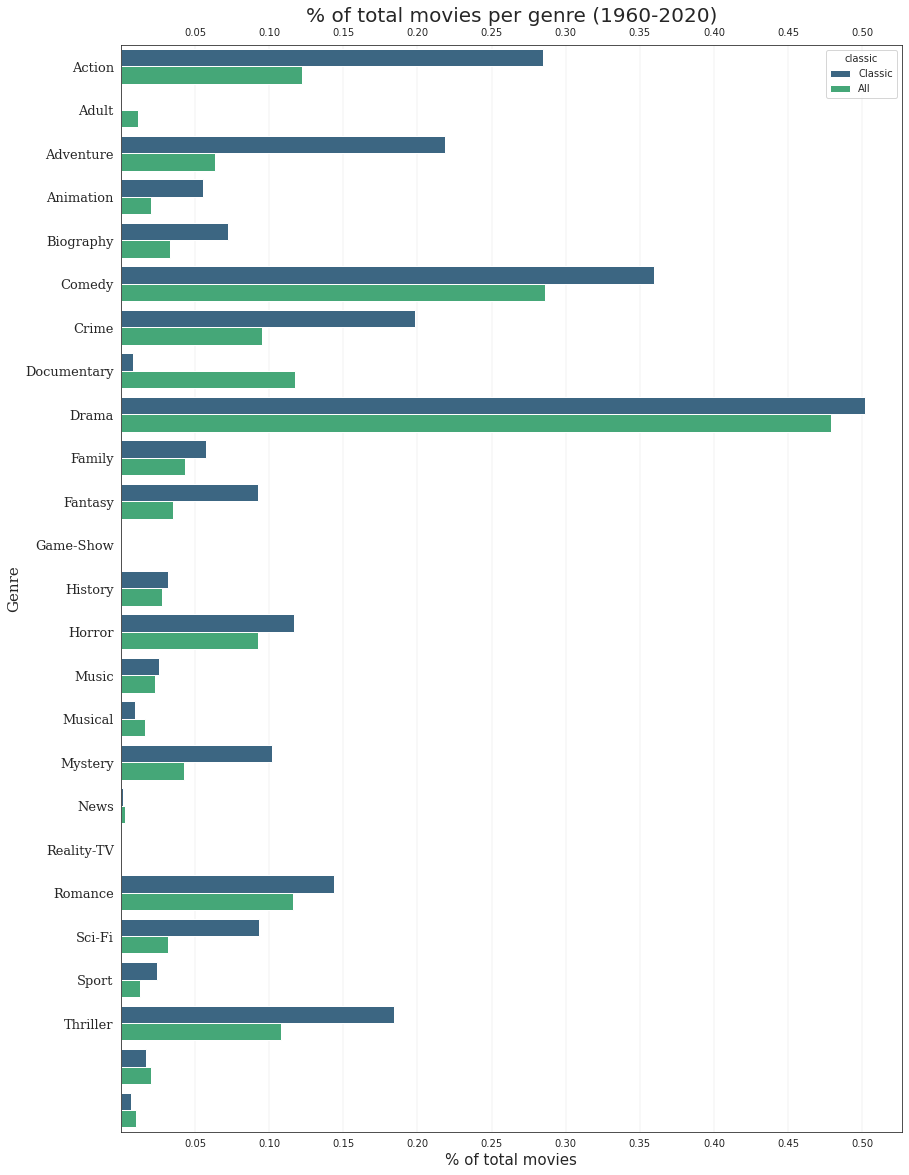

In [ ]:
import seaborn as sns
sns.set_style("white")
fig, ax = plt.subplots(figsize=(14,20))
ax = sns.barplot(y='genre', x='pct', hue='classic', data=graph, palette='viridis')
ax.grid(color='grey', linestyle='-', linewidth=0.1, axis='x')
ax.set_xticks([0.05, 0.10, .15, .20, .25, .30, .35, .40, .45, .50])
ax.set_yticklabels(graph.genre[:23], size = 13, fontfamily='serif')
ax.set_xlabel('% of total movies', fontsize=15)
ax.set_ylabel('Genre', fontsize=15, fontfamily='serif')
ax.tick_params(labelbottom=True,labeltop=True)
plt.title('% of total movies per genre (1960-2020)', fontsize=20)

We find some very clear differences, mostly in the genres Action and Adventure. Action movies comprise around 12% of total movies, but almost 30% of these so-called Classic movies belong to the Action genre. <br>We find a similar situation with the Adventure genre movies. This suggests that we must control for a movie's genre in the model.

Let's see how certain genres' popularity has evolved through time.

In [ ]:
genres_prog = genres_analysis.groupby(by='startYear').agg({'Horror': 'sum', 'Comedy': 'sum', \
                                                           'Drama':'sum', 'Sci-Fi':'sum', 'tconst': 'count'})
genres_prog.reset_index(inplace=True)
genres_prog['%_horror'] = genres_prog['Horror'] / genres_prog['tconst'] * 100
genres_prog['%_comedy'] = genres_prog['Comedy'] / genres_prog['tconst'] * 100
genres_prog['%_drama'] = genres_prog['Drama'] / genres_prog['tconst'] * 100
genres_prog['%_scifi'] = genres_prog['Sci-Fi'] / genres_prog['tconst'] * 100
genres_prog = genres_prog.iloc[:-1,:]

Text(0.5, 1.0, 'Progression of Horror films through time')

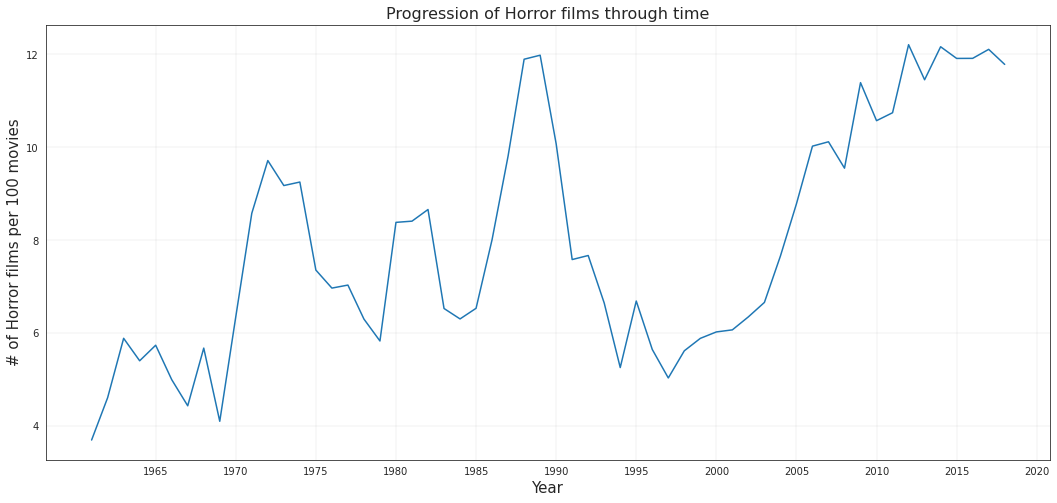

In [ ]:
ax = plt.subplots(figsize=(18,8))
ax = sns.lineplot(x=genres_prog['startYear'], y=genres_prog['%_horror'], legend='brief')
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('# of Horror films per 100 movies', fontsize=15)
ax.grid(color='grey', linestyle='-', linewidth=0.1)
ax.set_xticks([1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020])
plt.title('Progression of Horror films through time', fontsize=16)

We see that the production of Horror films decreased heavily during the 90's after the golden age of the genre in the 80's. <br>
It then started slowly increasing again after year 2000 and nowadays it seems to be quite popular again.

Text(0.5, 1.0, 'Progression of Sci-Fi films through time')

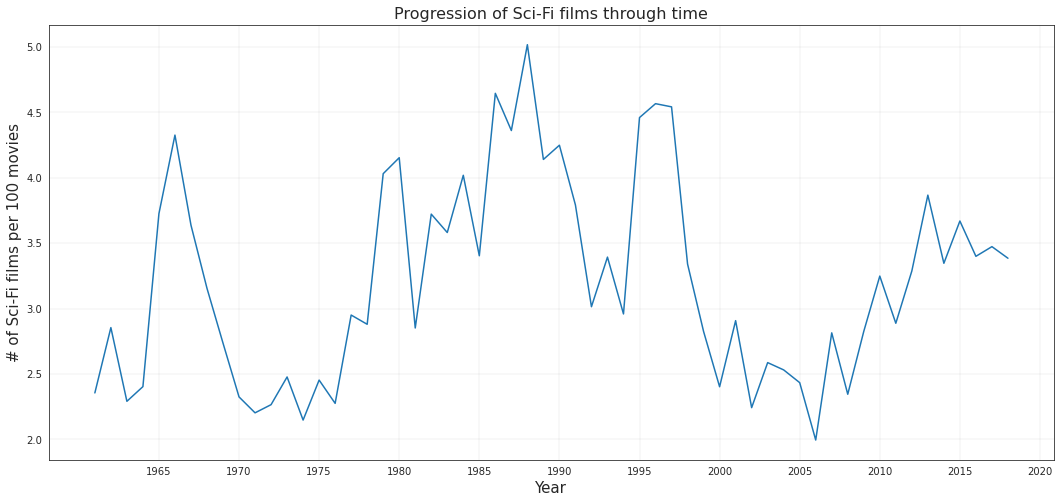

In [ ]:
ax = plt.subplots(figsize=(18,8))
ax = sns.lineplot(x=genres_prog['startYear'], y=genres_prog['%_scifi'], legend='brief')
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('# of Sci-Fi films per 100 movies', fontsize=15)
ax.grid(color='grey', linestyle='-', linewidth=0.1)
ax.set_xticks([1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020])
plt.title('Progression of Sci-Fi films through time', fontsize=16)

#### Year of Release

In [ ]:
class ReleaseYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y): return self
    def transform(self, X):
        res = []
        for e in X:
            res.append({'release_year': int(e['startYear'])})
        return res

Text(0.5, 1.0, 'Year vs. logVotes')

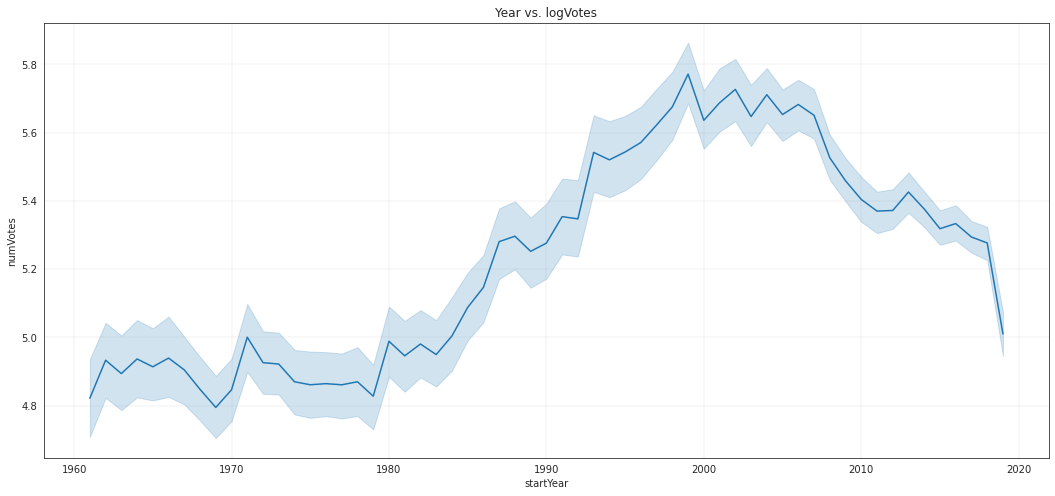

In [ ]:
ax = plt.subplots(figsize=(18,8))
ax = sns.lineplot(x=movies['startYear'], y=np.log(movies['numVotes']))
ax.grid(color='grey', linestyle='-', linewidth=0.1)
plt.title('Year vs. logVotes')

We see that the number of votes increases until the beginning of the 2000's and then slowly goes down.